In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import cv2
import numpy as np
import torch
import torchvision

from PIL import Image, ImageFont, ImageDraw, ImageEnhance
import matplotlib.pyplot as plt

In [2]:
import argparse
from src.solver import TASKS
from src.core import YAMLConfig

config = '/workspace/chanyoung/code/MODU/configs/RM-DETR_lulu/r50_multi.yml'
pt_path = '/workspace/chanyoung/code/MODU/output/lulu/mutil_channel/seg_r50_250410/best.pth'
cfg = YAMLConfig(
       config, resume=pt_path, use_amp=False, tuning=False
    )
solver = TASKS[cfg.yaml_cfg["task"]](cfg)
print(solver)

In [3]:
device = "cuda"
solver.setup
solver.eval()
model = solver.model
model.to(device)
model.eval()
postprocessor = solver.postprocessor
print(postprocessor)

Downloading: "https://github.com/lyuwenyu/storage/releases/download/v0.1/ResNet50_vd_ssld_v2_pretrained_from_paddle.pth" to /root/.cache/torch/hub/checkpoints/ResNet50_vd_ssld_v2_pretrained_from_paddle.pth
100%|██████████| 90.0M/90.0M [00:03<00:00, 29.9MB/s]


Load PResNet50 state_dict
loading annotations into memory...
Done (t=0.17s)
creating index...
index created!
resume from /workspace/chanyoung/code/MODU/output/lulu/mutil_channel/seg_r50_250410/best.pth
Loading last_epoch
Loading model.state_dict
Loading ema.state_dict
RMDETRPostProcessor(use_focal_loss=True, num_classes=2, num_top_queries=300)


In [7]:
import torch
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt

def visualize_all_objects_above_threshold(post_output, image_path, target_size=(640, 640), score_threshold=0.5):
    labels = post_output['labels'].detach().cpu().numpy()
    boxes = post_output['boxes'].detach().cpu().numpy()
    scores = post_output['scores'].detach().cpu().numpy()
    masks = post_output['masks'].detach().cpu().numpy()

    # 이미지 로드 및 리사이즈
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, target_size)
    H, W = target_size

    for idx in range(len(scores)):
        if scores[idx] < score_threshold:
            continue
        label = labels[idx]
        box = boxes[idx]
        score = scores[idx]
        mask = masks[idx] # (1, H, W) → (H, W)

        # 마스크 이진화
        print(mask.shape)
        mask = (mask > 0.3).astype(np.uint8)

        # 바운딩 박스 좌표
        x1, y1, x2, y2 = map(int, box)

        # 클래스별 색상 정의
        if label == 1:
            color = (255, 0, 0)  # 빨강
        elif label == 2:
            color = (0, 0, 255)  # 파랑
        else:
            color = (0, 255, 0)  # 예외 클래스는 초록 (혹시 모를 경우)

        # 마스크 영역 시각화
        color_overlay = np.array(color, dtype=np.uint8)
        image[mask == 1] = image[mask == 1] * 0.5 + color_overlay * 0.5

        # 바운딩 박스와 텍스트
        cv2.rectangle(image, (x1, y1), (x2, y2), color, 1)
        print(x1,y1,x2,y2)
        # cv2.putText(image, f"Class: {label}, Score: {score:.2f}", (x1, y1 - 10),
        #             cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # 결과 출력
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.axis('off')
    plt.show()


1280
(640, 640)
109 526 123 534
(640, 640)
212 80 221 85
(640, 640)
188 535 200 543
(640, 640)
519 209 531 218
(640, 640)
590 271 597 276
(640, 640)
458 380 465 384
(640, 640)
212 477 223 485
(640, 640)
265 248 279 258
(640, 640)
274 450 283 457
(640, 640)
66 306 74 310
(640, 640)
56 286 64 290
(640, 640)
468 129 475 133
(640, 640)
351 100 358 104
(640, 640)
432 116 438 120
(640, 640)
83 540 92 547
(640, 640)
562 507 571 514
(640, 640)
603 369 614 379
(640, 640)
366 568 373 573
(640, 640)
365 446 375 452
(640, 640)
604 369 613 378
(640, 640)
380 574 388 579
(640, 640)
104 517 110 521
(640, 640)
430 347 438 354
(640, 640)
113 263 122 269


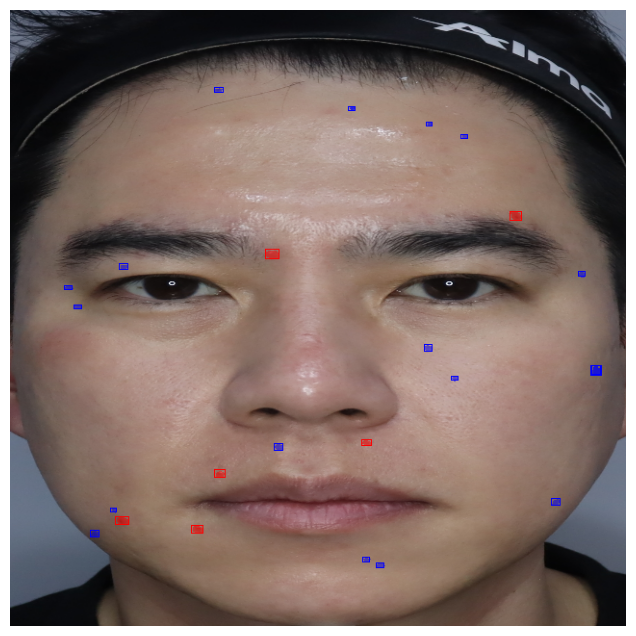

In [8]:
img_path = '/workspace/chanyoung/data/cropped/multi_channel/images/A0022_733297.png'
image = Image.open(img_path)

transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((640, 640)),
    torchvision.transforms.ToTensor()
])

input_tensor = transform(image).unsqueeze(0).to('cuda' if torch.cuda.is_available() else 'cpu')

output = model(input_tensor)
# print(output)
post_output = postprocessor(output, torch.tensor([[640, 640]]).to(input_tensor.device))
print(sum(post_output[0]['masks'][0].shape))
# 시각화: score 0.5 이상 객체 전부
visualize_all_objects_above_threshold(post_output[0], img_path, target_size=(640, 640), score_threshold=0.5)
